<h1> Variational Autoencoder </h1>
Traditional Autoencoders form dense representations with not a lot of meaningful "structure". This is fine when all you want to do is compress an input and then reconstruct it, but what if you then want to generate new images by sampling the representation space (latent space)? Small movements is the latent space lead to large and discontinuous jumps in the reconstructed output. We need to apply an additional loss to force the created latent space to be smooth and nicely structured.
<img src="https://miro.medium.com/max/1687/1*22cSCfmktNIwH5m__u2ffA.png" width="1200" align="center">

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm
from dataset_filtering import filtered_sets

In [45]:
batch_size = 128
lr = 1e-4

# Number of Training epochs
nepoch = 200

# The size of the Latent Vector
# latent_size = 256
# latent_size = 2048
latent_size = 16384
root = "D:/Datasets/"

In [46]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
print(device)

cuda:0


<h3>Create a CelebA dataset and dataloader</h3>

In [47]:
# Define our transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])

In [48]:
train_images, val_images, test_images = filtered_sets()

# Update the train and test datasets to include only filtered images without using Datasets.CelebA from Torchvision
class CustomCelebADataset(Dataset):
    def __init__(self, root, split, transform, filtered_images):
        self.root = root
        self.split = split
        self.transform = transform
        self.filtered_images = filtered_images
        self.image_dir = os.path.join(root, 'celeba', 'img_align_celeba')
        self.image_paths = [os.path.join(self.image_dir, img) for img in filtered_images]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_set = CustomCelebADataset(root=root, split='train', transform=transform, filtered_images=train_images)
print(f"Train set root: {train_set.root}")
print(f"Train set split: {train_set.split}")
print(f"Train set transform: {train_set.transform}")
print(f"Train set filtered images: {train_set.filtered_images[:5]}")  # Print first 5 filtered images for inspection
print(f"Train set image directory: {train_set.image_dir}")
print(f"Train set image paths: {train_set.image_paths[:5]}")  # Print first 5 image paths for inspection

val_set = CustomCelebADataset(root=root, split='val', transform=test_transform, filtered_images=val_images)

test_set = CustomCelebADataset(root=root, split='test', transform=test_transform, filtered_images=test_images)

print(f"Train set size after filtering: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size after filtering: {len(test_set)}")

# Update the data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


Train set root: D:/Datasets/
Train set split: train
Train set transform: Compose(
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
Train set filtered images: ['094652.jpg', '006893.jpg', '068999.jpg', '180362.jpg', '116560.jpg']
Train set image directory: D:/Datasets/celeba\img_align_celeba
Train set image paths: ['D:/Datasets/celeba\\img_align_celeba\\094652.jpg', 'D:/Datasets/celeba\\img_align_celeba\\006893.jpg', 'D:/Datasets/celeba\\img_align_celeba\\068999.jpg', 'D:/Datasets/celeba\\img_align_celeba\\180362.jpg', 'D:/Datasets/celeba\\img_align_celeba\\116560.jpg']
Train set size after filtering: 36752
Validation set size: 4595
Test set size after filtering: 4594


In [49]:
print(f"Train set size after filtering: {len(train_set)}")
print(f"Test set size after filtering: {len(test_set)}")
print(f"Train loader size: {len(train_loader)}")
print(f"Test loader size: {len(test_loader)}")

Train set size after filtering: 36752
Test set size after filtering: 4594
Train loader size: 288
Test loader size: 36


In [50]:
"""
# Define a smaller subset size
subset_size = 2000

# Select a smaller subset of filtered images
small_filtered_images = filtered_images[:subset_size]

# Create smaller train and test datasets
small_train_set = CustomCelebADataset(root=root, split='train', transform=transform, filtered_images=small_filtered_images)
small_test_set = CustomCelebADataset(root=root, split='test', transform=test_transform, filtered_images=small_filtered_images)

# Create smaller data loaders
small_train_loader = DataLoader(small_train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
small_test_loader = DataLoader(small_test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Print the sizes of the smaller datasets and loaders
print(f"Small train set size: {len(small_train_set)}")
print(f"Small test set size: {len(small_test_set)}")
print(f"Number of batches in small train loader: {len(small_train_loader)}")
print(f"Number of batches in small test loader: {len(small_test_loader)}")
"""

'\n# Define a smaller subset size\nsubset_size = 2000\n\n# Select a smaller subset of filtered images\nsmall_filtered_images = filtered_images[:subset_size]\n\n# Create smaller train and test datasets\nsmall_train_set = CustomCelebADataset(root=root, split=\'train\', transform=transform, filtered_images=small_filtered_images)\nsmall_test_set = CustomCelebADataset(root=root, split=\'test\', transform=test_transform, filtered_images=small_filtered_images)\n\n# Create smaller data loaders\nsmall_train_loader = DataLoader(small_train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)\nsmall_test_loader = DataLoader(small_test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)\n\n# Print the sizes of the smaller datasets and loaders\nprint(f"Small train set size: {len(small_train_set)}")\nprint(f"Small test set size: {len(small_test_set)}")\nprint(f"Number of batches in small train loader: {len(small_train_loader)}")\nprint(f"Number of batches 

In [51]:
"""
# Print information about the data loader
def print_loader_info(loader):
    first_batch = next(iter(loader))  # Get the first batch
    print(f"Number of batches: {len(loader)}")
    print("Batch 1:")
    print(f"  Number of images in batch: {len(first_batch)}")
    print(f"  Shape of images: {first_batch[0].shape}")

print("Train Loader Info:")
print_loader_info(train_loader)

print("\nTest Loader Info:")
print_loader_info(test_loader)
"""

'\n# Print information about the data loader\ndef print_loader_info(loader):\n    first_batch = next(iter(loader))  # Get the first batch\n    print(f"Number of batches: {len(loader)}")\n    print("Batch 1:")\n    print(f"  Number of images in batch: {len(first_batch)}")\n    print(f"  Shape of images: {first_batch[0].shape}")\n\nprint("Train Loader Info:")\nprint_loader_info(train_loader)\n\nprint("\nTest Loader Info:")\nprint_loader_info(test_loader)\n'

## KL Divergence penalty (loss)

The KL divergance between two normal distributions where:

\begin{equation*}
p(x) = N(\mu_p,\sigma_p)
\end{equation*}

\begin{equation*}
q(x) = N(\mu_q,\sigma_q)
\end{equation*}
                                
                                
Is                               
\begin{equation*}
KL(p,q) = \ln(\frac{\sigma_q}{\sigma_p}) + \frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{2\sigma_q^2} - \frac{1}{2}
\end{equation*}

With a VAE using the Encoder we produce a $\sigma$ and a $\mu$ per dimension and sample from normal distribution (once per dimension) with the given $\sigma$ and $\mu$. We then pass this sampled vector to the Decoder which will try and reconstruct the original image.<br>
The KL penalty (or loss) tries to force the distribution from the encoder to be that of a unit gaussian where $\sigma=1$ and $\mu =0$ (also known as a Standard Normal Distribution).<br>
To do this we create a loss using the KL Divergence (a value that is always positive) between the distribution produced by the encoder and that of a unit gaussian.<br>


So the above becomes:
\begin{equation*}
p(x) = N(\mu_p,\sigma_p)
\end{equation*}

\begin{equation*}
q(x) = N(0,1)
\end{equation*}

\begin{equation*}
KL(p,q) = \ln(\frac{1}{\sigma_p}) + \frac{\sigma_p^2 + (\mu_p - 0)^2}{2*1^2} - \frac{1}{2}
\end{equation*}

Which we can simplify to:
\begin{equation*}
KL(p,q) = -\frac{1}{2}(2\ln(\sigma_p) - \sigma_p^2 - \mu_p^2 + 1)
\end{equation*}

If we minimise this we bring our distribution closer to a unit gaussian <br><br>
Note: $\sigma$ must always be $\ge0$, instead of forcing this on our network we usually use $\ln(\sigma^2)$ or the "log variance" in its place (literally the log of the variance $\sigma^2$ which simplifies to $2\ln(\sigma)$ which we can see in our equation above). This value is continuous in the range of $-\infty$ to $\infty$

## Why do we even bother??
There is more then meets the eye with what is actually going in a VAE and what happens when we implement a KL penalty, for a good explanation we won't be able to beat check-out these great write-ups: <br>
[Blog: Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)<br>
[Blog: Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

What is the ELBO and how does it apply to a VAE? <br>
[Youtube: Evidence Lower Bound (ELBO) - CLEARLY EXPLAINED!](https://www.youtube.com/watch?v=IXsA5Rpp25w&ab_channel=KapilSachdeva)

In [52]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)
    
    # Here is our KL divergance loss implemented in code
    # We will use the mean across the dimensions instead of the sum (which is common and would require different scaling)
    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    
    # We'll tune the "strength" of KL divergance loss to get a good result 
    loss = recon_loss + 0.1 * kl_loss
    return loss

## VAE Network
The structure is very similar to a vanilla Auto Encoder with the addition of a $\sigma$ output on the encoder.<br>
It is functionally different as we sample from a standard normal distribution and scale it with $\sigma$ and shift with $\mu$.<br> This functionally the same as sampling from $N(\mu,\sigma)$<br>
Note: we only do this during training, during test time we just use $\mu$

In [53]:
# DownBlock for the Encoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_out)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x_skip = self.conv3(x)
        
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.conv2(x) + x_skip
        
        return F.elu(self.bn2(x))
    
# UpBlock for the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = F.elu(self.bn2(x_in))
        
        x_skip = self.up_nn(self.conv3(x))
        
        x = self.up_nn(F.elu(self.bn2(self.conv1(x))))
        return self.conv2(x) + x_skip

# Encoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=128):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch)
        self.conv_block2 = DownBlock(ch, ch * 2)
        self.conv_block3 = DownBlock(ch * 2, ch * 4)
        
        # Si on veut flatten :
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        self.conv_mu = nn.Conv2d(4 * ch, z, 4, 1)
        self.conv_logvar = nn.Conv2d(4 * ch, z, 4, 1)

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = F.elu(self.conv_1(x))
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Si on flatten :
        x = self.pool(x)

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        x = self.sample(mu, logvar)
        
        return x, mu, logvar

# Decoder
class Decoder(nn.Module):
    def __init__(self, channels, ch=32, z=128):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        
        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_block3 = UpBlock(ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)
        self.upsample = nn.Upsample(size=(218, 178), mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = F.elu(self.conv_block3(x))
        
        x = self.conv_out(x)
        x = self.upsample(x)  # Adjust the size to match the input dimensions

        return torch.tanh(x)

# VAE combining Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, channels, ch=32, z=128):
        super(VAE, self).__init__()
        self.encoder = Encoder(channels, ch, z)
        self.decoder = Decoder(channels, ch, z)

    def forward(self, x):
        # Encode
        z, mu, logvar = self.encoder(x)
        # print(f"Encoded shape: {z.shape}")
        
        # Decode
        x_recon = self.decoder(z)
        # print(f"Decoded shape: {x_recon.shape}")
        
        return x_recon, mu, logvar

<h3>Visualize our data</h3>

In [54]:
# Get a test image
dataiter = iter(test_loader)
test_images_iter = next(dataiter)[0]

# View the shape
test_images_iter.shape

torch.Size([3, 218, 178])

In [55]:
# Instantiate and test the VAE
channels = 3  # Assuming the input images have 3 channels (RGB)
vae_net = VAE(channels).to(device)

# Add a batch dimension to the test image
test_images_batch = test_images_iter.unsqueeze(0)

recon_data, mu, logvar = vae_net(test_images_batch.to(device))
print(f"Input shape: {test_images_batch.shape}")
print(f"Reconstructed shape: {recon_data.shape}")

Input shape: torch.Size([1, 3, 218, 178])
Reconstructed shape: torch.Size([1, 3, 218, 178])


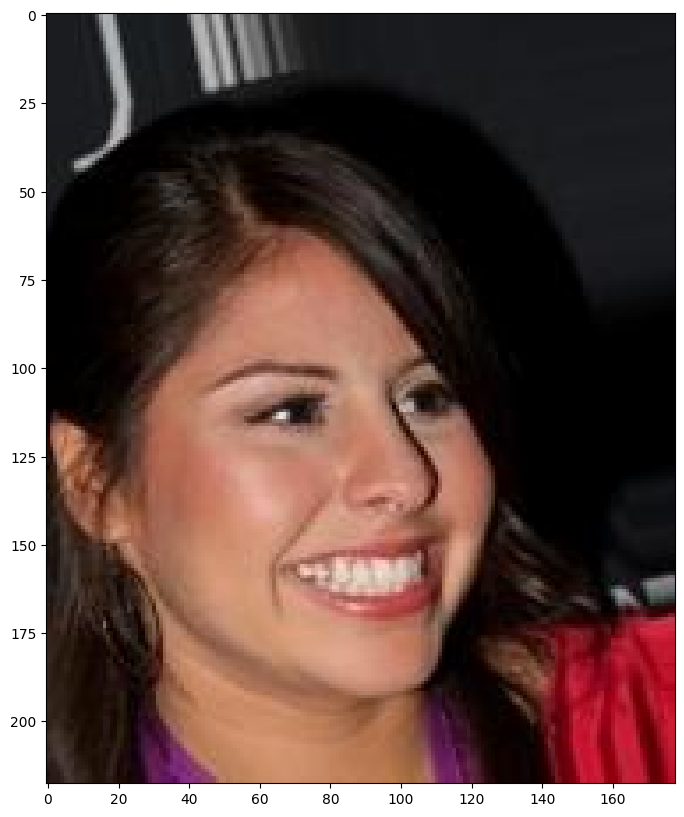

In [56]:
# Visualize the data!!!
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images_iter[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

<h3>Create Network and Optimizer</h3>

In [57]:
# Create our network
vae_net = VAE(channels=3, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))

# Create loss logger
loss_log = []
train_loss = 0

<h4>Network output</h4>

In [58]:
# Add a batch dimension to the test image
test_images_batch = test_images_iter.unsqueeze(0)

# Pass through a test image to make sure everything is working
recon_data, mu, logvar = vae_net(test_images_batch.to(device))

# View the Latent vector shape
mu.shape

torch.Size([1, 16384, 1, 1])

<h2>Start training!</h2>

In [ ]:
# Load the model if it exists
if os.path.exists("vae_checkpoint.pth"):
    checkpoint = torch.load("vae_checkpoint.pth")
    vae_net.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    loss_log = checkpoint["loss_log"]
    nepoch = checkpoint["epoch"]
    print("Checkpoint loaded.")
else:
    print("No checkpoint found, starting fresh.")

pbar = trange(0, nepoch, leave=False, desc="Epoch")   
vae_net.train()
train_loss = 0
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data.to(device)

        # Forward pass the image in the data tuple
        recon_data, mu, logvar = vae_net(image)
        
        # Calculate the loss
        loss = vae_loss(recon_data, image, mu, logvar)
        
        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()

        # Take a training step
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the checkpoint every epoch
    checkpoint = {
        "epoch": epoch,
        "model_state": vae_net.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss_log": loss_log,

        "hyperparams": {
            "batch_size": batch_size,
            "lr": lr,
            "latent_size": latent_size
        },
        "train_images": train_images,
        "val_images": val_images,
        "test_images": test_images
    }
    
    # Save the checkpoint
    torch.save(checkpoint, "vae_checkpoint.pth")

    # Save the model every 10 epochs

    if epoch % 10 == 0:
        torch.save(vae_net.state_dict(), f"vae_epoch_{epoch}.pth")

# Save the final model
torch.save(vae_net.state_dict(), "vae_flatten_final.pth")
print("Final model saved.")

No checkpoint found, starting fresh.


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

Training:   0%|          | 0/288 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Results!

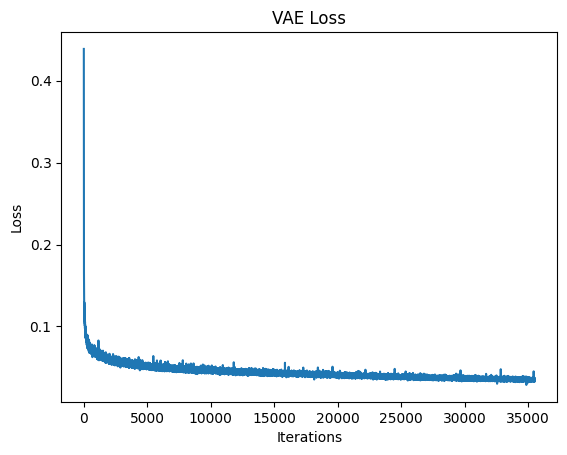

In [60]:
len(loss_log)
plt.plot(loss_log[:])
plt.title("VAE Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [61]:
vae_net.eval()
# test_images_batch = test_images.unsqueeze(0)  # Add a batch dimension
recon_data, mu, logvar = vae_net(test_images_batch.to(device))

In [62]:
recon_data.shape
recon_data.squeeze(0).cpu().detach().numpy()

array([[[-0.7961473 , -0.81291735, -0.8284396 , ..., -0.75838834,
         -0.74186754, -0.7243943 ],
        [-0.8107351 , -0.82670134, -0.84143865, ..., -0.7746337 ,
         -0.7586658 , -0.74173135],
        [-0.82438105, -0.8395596 , -0.85353154, ..., -0.78991723,
         -0.77451235, -0.7581308 ],
        ...,
        [-0.53328705, -0.5474441 , -0.5612947 , ...,  0.25860018,
          0.24778453,  0.23690687],
        [-0.5155109 , -0.53103197, -0.54620445, ...,  0.23418622,
          0.22171503,  0.20917101],
        [-0.49727973, -0.5142113 , -0.53075135, ...,  0.20947328,
          0.19532469,  0.18109447]],

       [[-0.70568496, -0.72156256, -0.73671585, ..., -0.7439554 ,
         -0.7322313 , -0.7200568 ],
        [-0.7191298 , -0.73487246, -0.7498612 , ..., -0.76329756,
         -0.75264555, -0.74158466],
        [-0.73205686, -0.7476394 , -0.76244   , ..., -0.7813617 ,
         -0.77170855, -0.7616863 ],
        ...,
        [-0.7556265 , -0.7755312 , -0.7940049 , ..., -

In [63]:
vae_net.encoder(test_images_batch.to(device))

(tensor([[[[ 0.1953]],
 
          [[-0.2150]],
 
          [[-0.4304]],
 
          ...,
 
          [[ 0.6253]],
 
          [[-1.4237]],
 
          [[-0.3950]]]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[-0.2015]],
 
          [[ 0.2673]],
 
          [[ 0.2790]],
 
          ...,
 
          [[ 0.2875]],
 
          [[-0.3110]],
 
          [[-0.0541]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>),
 tensor([[[[ 0.0098]],
 
          [[-0.0002]],
 
          [[-0.0378]],
 
          ...,
 
          [[-0.1709]],
 
          [[-0.0069]],
 
          [[-0.1072]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>))

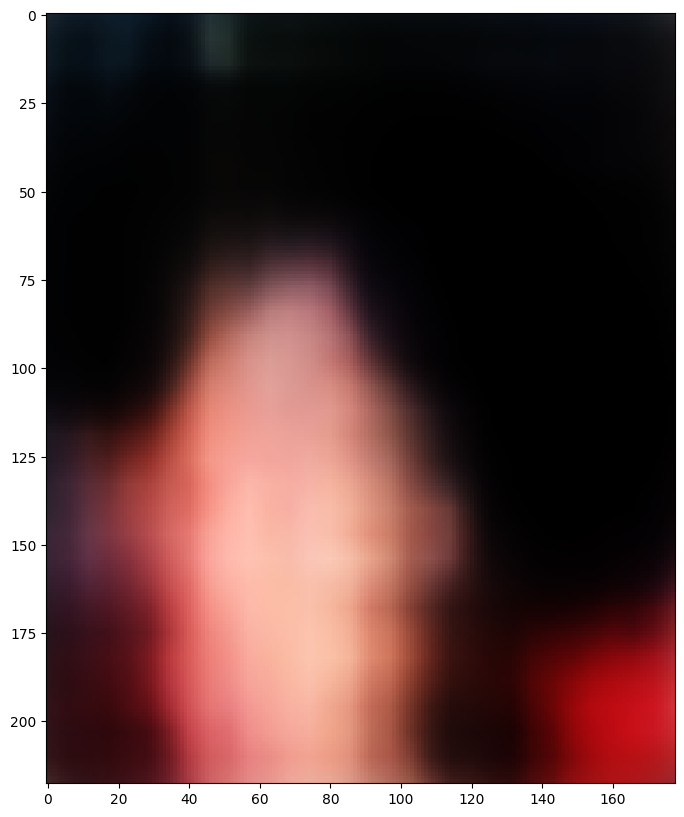

In [64]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Ground Truth

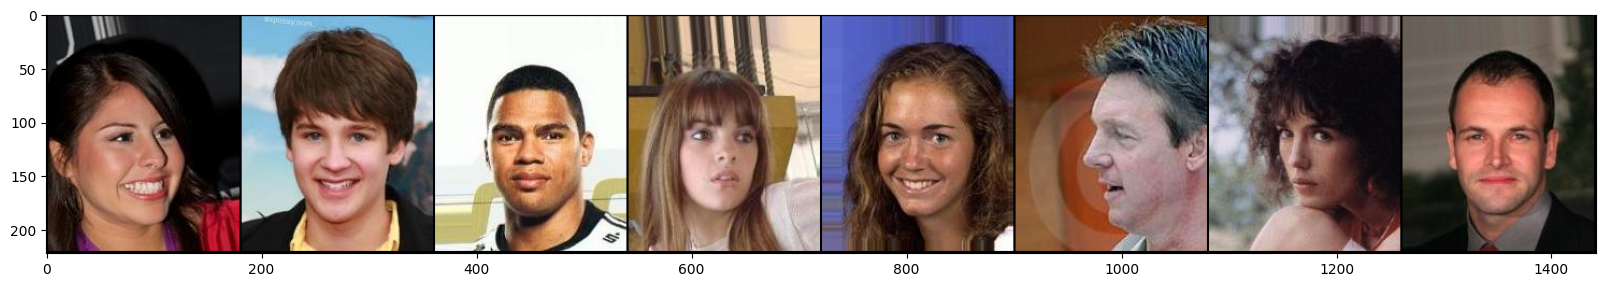

In [65]:
# Load the first 8 images from test_images and convert them to tensors
loaded_images = [transform(Image.open(os.path.join(root, 'celeba', 'img_align_celeba', img)).convert('RGB')) for img in test_images[:8]]

# Stack the tensors into a single batch
image_batch = torch.stack(loaded_images)

# Create a grid of images
plt.figure(figsize=(20, 10))
out = vutils.make_grid(image_batch, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Reconstruction

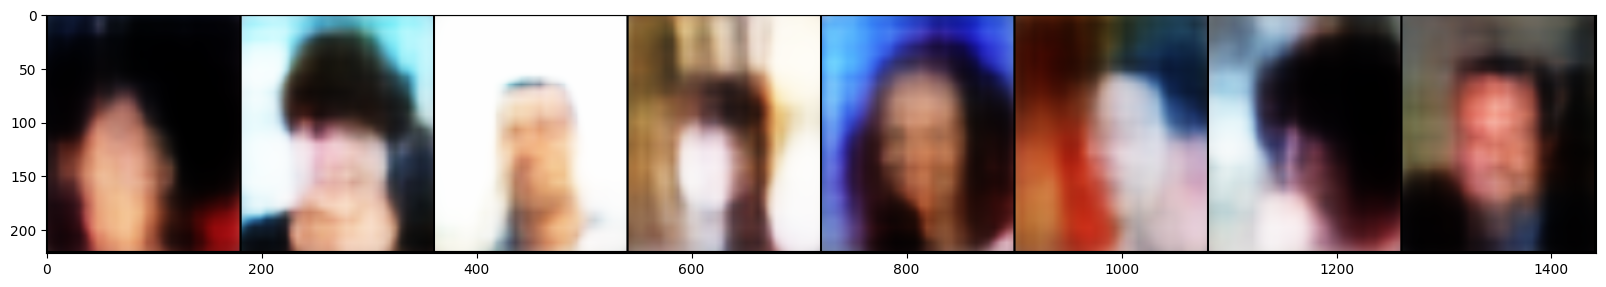

In [66]:
# Pass the image batch through the VAE to get the reconstructed images
vae_net.eval()
reconstructed_images, _, _ = vae_net(image_batch.to(device))

# Visualize the reconstructed images
plt.figure(figsize=(20, 10))
out = vutils.make_grid(reconstructed_images.detach().cpu(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))